**!!! This is Christian's version of the notebook to test some things !!!**

**!!! To be deleted later !!!**

# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
# Import packages

import warnings

import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt
import pandas as pd

import time

In [2]:
#ds_pws = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_data_FZ_filtered_rainfall.nc')
ds_pws = xr.open_dataset('OpenSense_PWS_example_format_data.nc')

In [3]:
#slice to one month
ds_pws = ds_pws.sel(time = slice('2017-07-01','2017-07-31'))

## Calculate distance matrix

In [4]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

In [5]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

In [6]:
distance_matrix

<xarray.DataArray (id: 134, id_neighbor: 134)>
array([[    0.        ,   518.79828487,   531.99603941, ...,
        28532.23134009, 25291.03668667, 25994.5064412 ],
       [  518.79828487,     0.        ,   728.38027968, ...,
        28493.8273213 , 24995.94592241, 25633.14869253],
       [  531.99603941,   728.38027968,     0.        , ...,
        28000.75903421, 24846.06853717, 25603.62271956],
       ...,
       [28532.23134009, 28493.8273213 , 28000.75903421, ...,
            0.        , 14448.29575676, 18710.76846276],
       [25291.03668667, 24995.94592241, 24846.06853717, ...,
        14448.29575676,     0.        ,  4264.61589559],
       [25994.5064412 , 25633.14869253, 25603.62271956, ...,
        18710.76846276,  4264.61589559,     0.        ]])
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'

## Apply SO filter

In [7]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.15
beta = 0.2
n_stat = 2
max_distance = 10e3 # Boolean 2D data array, defining neihbours within max_distance for all stations
#neighbor_matrix = distance_matrix < max_distance

In [8]:
#so_flag = pypwsqc.flagging.so_filter(
#    ds_pws.rainfall,
#    ds_pws.nbrs_not_nan,
#    ds_pws.reference,
#    distance_matrix,
#    mint = 4032,
#    mrain = 100,
#    mmatch = 200,
#    gamma = 0.15,
#   beta = 0.2,
#    n_stat = 5,
#    max_distance = 10e3,
#)

In [9]:
# Default Bias Correction Factor
dbc = 1

In [10]:
# Boolean 2D array (id, time) of true (rain > 0) or false (rain =< 0) for all stations and timesteps
rainy_timesteps = ds_pws.rainfall > 0

In [11]:
# cumulative rainy timesteps per station
cum_rainy_timesteps = rainy_timesteps.cumsum(dim="time")

In [12]:
# initialize ugly solution
numbers = np.empty_like(ds_pws.rainfall)
numbers[:, :] = range(len(ds_pws.time))
numbers = numbers.astype(int)
ds_pws["number"] = (("id", "time"), numbers)

In [13]:
# initalize with empty numpy array
so_flag = np.ones_like(ds_pws.rainfall)
biascorrectiontable = np.ones_like(ds_pws.rainfall)

## Only fixed evaluation period

In [14]:
#%load_ext line_profiler

In [15]:
%%time
ds_pws = ds_pws.load()
tt = time.time()

CPU times: user 3.17 ms, sys: 3.25 ms, total: 6.42 ms
Wall time: 4.05 ms


In [175]:
%%time

# initalize with empty numpy array
so_flag = np.ones_like(ds_pws.rainfall)
median_correlation_table = np.ones_like(ds_pws.rainfall)
biascorrectiontable = np.ones_like(ds_pws.rainfall)

# initialize ugly solution
numbers = np.empty_like(ds_pws.rainfall)
numbers[:, :] = range(len(ds_pws.time))
numbers = numbers.astype(int)
ds_pws["number"] = (("id", "time"), numbers)

rainy_timesteps = ds_pws.rainfall > 0
# cumulative rainy timesteps per station
cum_rainy_timesteps = rainy_timesteps.cumsum(dim="time")

for i, station_id in enumerate(ds_pws.id.data[:5]):  # enumerate(["ams1", "ams45", "ams17"]):
    print(station_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
        distance_matrix.sel(id=station_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=station_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )
    #print(neighbors.data)

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=station_id).isnull().all()
    ):
        so_flag[i, :] = -1
        print(' not enough neighbors with data')

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, mint+5)).data, start=mint
        ):
            evaluation_period_start = j - mint +1
            evaluation_period_end = j

            ds_pws_t_slice = ds_pws.isel(time=slice(evaluation_period_start, evaluation_period_end))

            print(timestep)

            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev
            #t1 = time.time()
            #if time.time() - tt > 30: # every now and then print some info
                #tt = time.time()
                #print('After 30 sec, station:', i, 'of', len(ds_pws.id), 'timestep:', j, 'of', len(ds_pws.time))
            
            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps

            # number of rainy timesteps within evaulation period from neighbors
            # matches = (
            #     rainy_timesteps.sel(id=neighbors)
            #     .isel(time=slice(evaluation_period_start, evaluation_period_end))
            #     .sum()
            #     .data
            # )
            matches = ds_pws_t_slice.sel(id=neighbors).rainfall.sum().data

            if matches < mmatch:
            # filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

            else:
                # suppress runtime warning
                #print(i, 'filter can be applied')
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        #print(k)
                        ds_pws_station = ds_pws_t_slice.rainfall.sel(id=station_id)
                        ds_pws_nbr = ds_pws_t_slice.rainfall.sel(id=neighbor_id)
                        
                        # # pearson correlation with neighboring stations
                        #corr = xr.corr(ds_pws_station, ds_pws_nbr) # <-- This is very very slow!!!!
                        #corr = np.corrcoef(ds_pws_station.data, ds_pws_nbr.data)[0,1] # Very fast but does not handle NaNs

                        # using numpy masked array to handle NaNs, 2x slower than np only
                        #import numpy.ma as ma
                        #corr = ma.corrcoef(ma.masked_invalid(ds_pws_station.data), ma.masked_invalid(ds_pws_nbr.data))[0, 1]

                        # pandas version, corr is fast but transformation to dataframe takes too much time
                        # df_station = ds_pws_station.to_dataframe()
                        # df_nbr = ds_pws_nbr.to_dataframe()
                        # coor = df_station.rainfall.corr(df_nbr.rainfall)
                        
                        # corr_values[k] = corr.data  

                        # # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        # delta_r = ds_pws_station -ds_pws_nbr 
                        # bias = np.nanmean(delta_r) / np.nanmean(ds_pws_nbr)
                     
                        # bias_values[k] = bias
                        
                        # median_correlation = np.median(corr_values)
                        # median_correlation_table[i, j] = median_correlation
                        
                        # # if median correlation is above threshold gamma,
                        # # calculate new bias correction factor
                        # if median_correlation > gamma:
                        #     #print('correlation is above threshold')
                        #     bias_values[np.isinf(bias_values)] = np.nan
                        #     median_bias = np.nanmedian(
                        #         bias_values
                        #     )  # median of bias of indivial bias to all neigbors
                        #     BCF_new = 1 / (1 + median_bias)
                        #     if np.abs(np.log(BCF_new / BCF_prev)) > np.log(1 + beta):
                        #         BCF_prev = BCF_new
                        #         biascorrectiontable[i,j] = BCF_new
                        #         #print('new BCF')

                        # # if the median of the pearson correlation with the neighbors is too low, 
                        # # it is a "station outlier"
                        # else:
                        #     so_flag[i, j] = 1
                        #     biascorrectiontable[i,j] = BCF_prev
                        #     #print('below threshold, station outlier, previous BCF')
                        # t2 = time.time()
            #print('timestep', j, 'took', t2 - t1, 'seconds to run')
    #so_flag.to_pickle('C:/Users/a002461/OPENSENSE/data/'+station_id+'.pkl')      
    # initialize an empty list, append to the list, convert to xarray

ams1
2017-07-15T00:00:00.000000000
2017-07-15T00:05:00.000000000
2017-07-15T00:10:00.000000000
2017-07-15T00:15:00.000000000
2017-07-15T00:20:00.000000000
ams2
2017-07-15T00:00:00.000000000
2017-07-15T00:05:00.000000000
2017-07-15T00:10:00.000000000
2017-07-15T00:15:00.000000000
2017-07-15T00:20:00.000000000
ams3
2017-07-15T00:00:00.000000000
2017-07-15T00:05:00.000000000
2017-07-15T00:10:00.000000000
2017-07-15T00:15:00.000000000
2017-07-15T00:20:00.000000000
ams4
2017-07-15T00:00:00.000000000
2017-07-15T00:05:00.000000000
2017-07-15T00:10:00.000000000
2017-07-15T00:15:00.000000000
2017-07-15T00:20:00.000000000
ams5
 not enough neighbors with data
CPU times: user 344 ms, sys: 11.4 ms, total: 355 ms
Wall time: 357 ms


In [127]:
xr.corr(ds_pws_station, ds_pws_nbr) # <-- This is very very slow!!!!

<xarray.DataArray 'rainfall' ()>
array(nan)
Coordinates:
    elevation  <U3 'nan'

In [140]:
np.corrcoef(ds_pws_station.data, np.roll(ds_pws_station.data, -1))[0,1]

nan

In [130]:
ds_pws_station.data

array([0.303, 0.101, 0.202, ..., 0.   , 0.   ,   nan])

In [152]:
df = ds_pws_station.to_dataframe()
df.rainfall.corr(df.rainfall.shift(-1))

0.6259656289085426

In [31]:
j

4036

In [40]:
so_flag[:5, j-5:j]

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1.]])

In [41]:
biascorrectiontable[:5 ,j-5:j]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [42]:
median_correlation_table[:5, j-5:j]

array([[ 1., nan, nan, nan, nan],
       [ 1., nan, nan, nan, nan],
       [ 1., nan, nan, nan, nan],
       [ 1., nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1.]])

## Try out SO filter myself

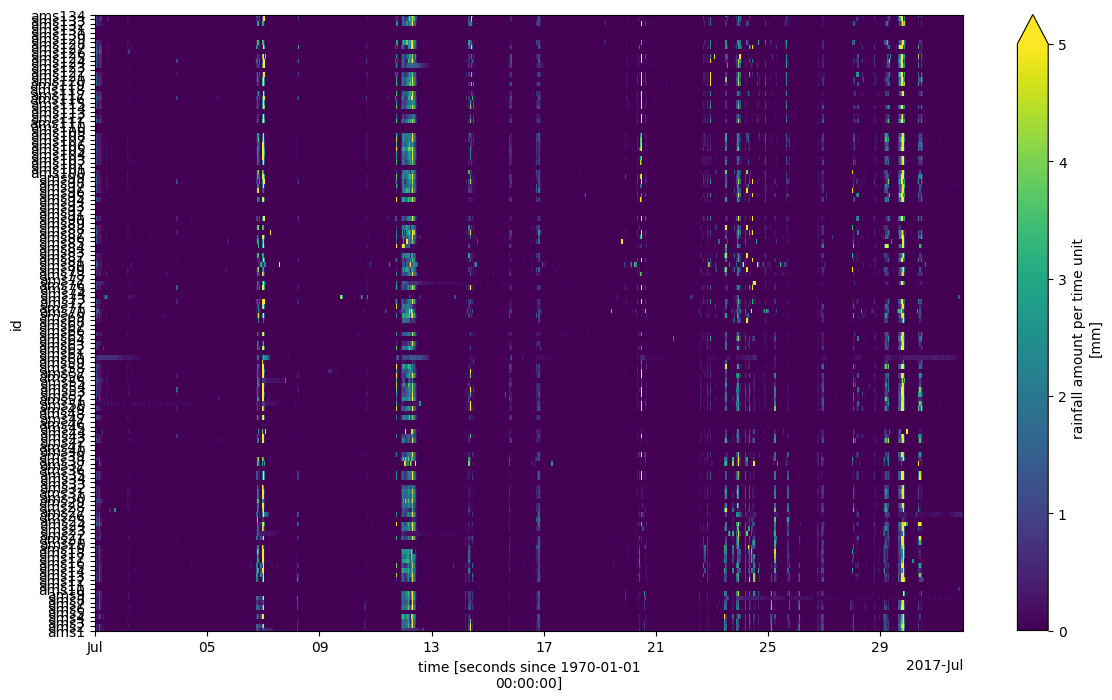

In [49]:
ds_pws.rainfall.resample(time='1h').sum().plot.pcolormesh(vmin=0, vmax=5, figsize=(14, 8));

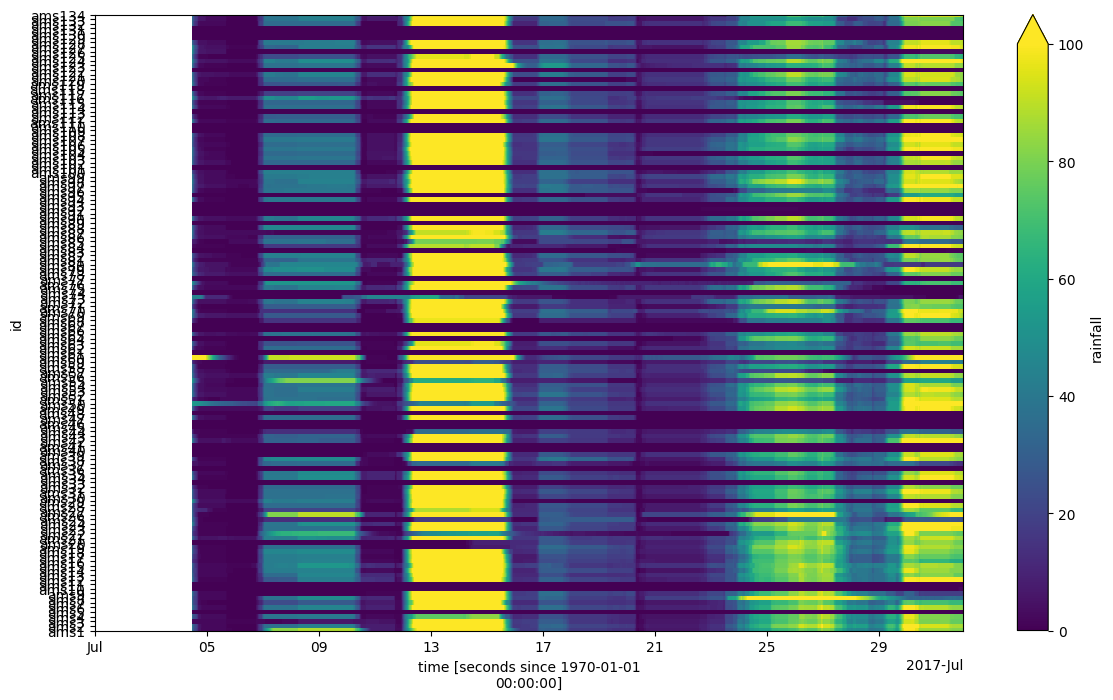

In [277]:
(ds_pws.rainfall > 0).rolling(time=1000).sum().plot.pcolormesh(vmin=0, vmax=100, figsize=(14, 8));

In [260]:
i = 10
max_distance = 10e3
ds_station = ds_pws.isel(id=i)
station_id = ds_station.id.values

nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
        distance_matrix.sel(id=station_id) > 0
    )

neighbor_ids = nbrs_within_range.id_neighbor.where(nbrs_within_range, drop=True)
ds_neighbors = ds_pws.sel(id=neighbor_ids)

station_id

array('ams11', dtype='<U6')

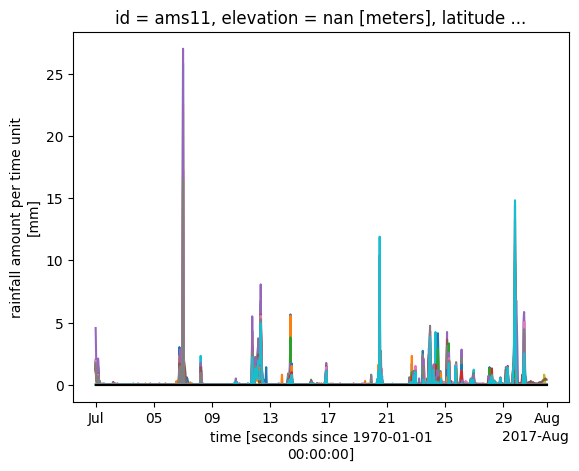

In [261]:
ds_neighbors.rainfall.resample(time='1h').sum().plot.line(x='time', add_legend=False);
ds_station.rainfall.resample(time='1h').sum().plot.line(x='time', add_legend=False, color='k');

In [262]:
d = ds_pws.rainfall
d.to_series()

id      time               
ams1    2017-07-01 00:00:00    0.101
        2017-07-01 00:05:00    0.202
        2017-07-01 00:10:00    0.101
        2017-07-01 00:15:00    0.202
        2017-07-01 00:20:00    0.101
                               ...  
ams134  2017-07-31 23:35:00    0.000
        2017-07-31 23:40:00    0.000
        2017-07-31 23:45:00    0.000
        2017-07-31 23:50:00    0.000
        2017-07-31 23:55:00    0.000
Name: rainfall, Length: 1196352, dtype: float64

In [263]:
def flag_station_outlier_for_one_station(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    
    corr = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)
    n_rainy_timesteps = (s_neighbors > 0).rolling(window_length, min_periods=1).sum()
    #return corr
    
    import pandas as pd
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
    ds['n_rainy_timesteps'] = xr.DataArray.from_series(n_rainy_timesteps)
    #ds['id'] = ds.id_neighbor.astype(str)
    return ds

corr = flag_station_outlier_for_one_station(ds_pws_station, ds_neighbors.rainfall, window_length=4000)

In [264]:
corr

<xarray.Dataset>
Dimensions:            (id_neighbor: 20, time: 8928)
Coordinates:
  * id_neighbor        (id_neighbor) object 'ams1' 'ams2' ... 'ams36' 'ams39'
  * time               (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
Data variables:
    corr               (id_neighbor, time) float64 nan nan nan ... nan nan nan
    n_rainy_timesteps  (id_neighbor, time) float64 1.0 2.0 3.0 ... 195.0 195.0

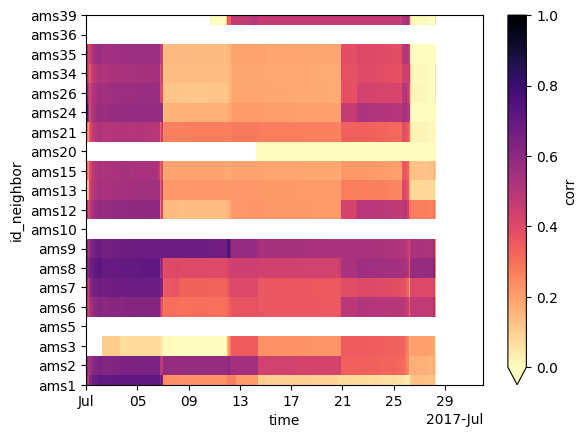

In [265]:
corr['id_neighbor'] = corr.id_neighbor.astype(str)
corr.corr.plot(vmin=0, vmax=1, cmap='magma_r')

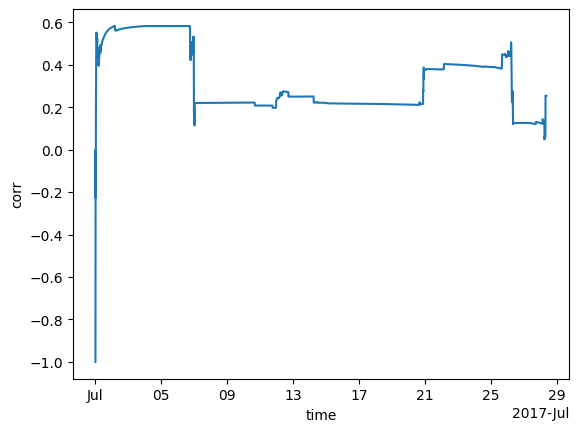

In [266]:
corr.corr.median(dim='id_neighbor').plot()

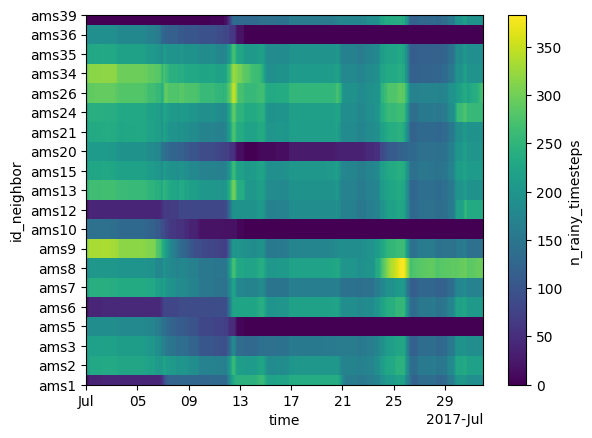

In [269]:
corr.n_rainy_timesteps.plot(); 

### Do it for all stations

In [279]:
%%time

max_distance = 10e3

corr_list = []
n_rainy_list = []

for i in range(len(ds_pws.id)):
    ds_station = ds_pws.isel(id=i)
    station_id = ds_station.id.values

    nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
            distance_matrix.sel(id=station_id) > 0
        )
    
    neighbor_ids = nbrs_within_range.id_neighbor.where(nbrs_within_range, drop=True)
    ds_neighbors = ds_pws.sel(id=neighbor_ids)

    ds_foo = flag_station_outlier_for_one_station(ds_station.rainfall, ds_neighbors.rainfall, window_length=1000)

    corr_list.append(ds_foo.corr.median(dim='id_neighbor'))


CPU times: user 20.7 s, sys: 6.2 s, total: 26.9 s
Wall time: 27.1 s


In [280]:
ds_pws['median_corr'] = (('id', 'time'), corr_list)

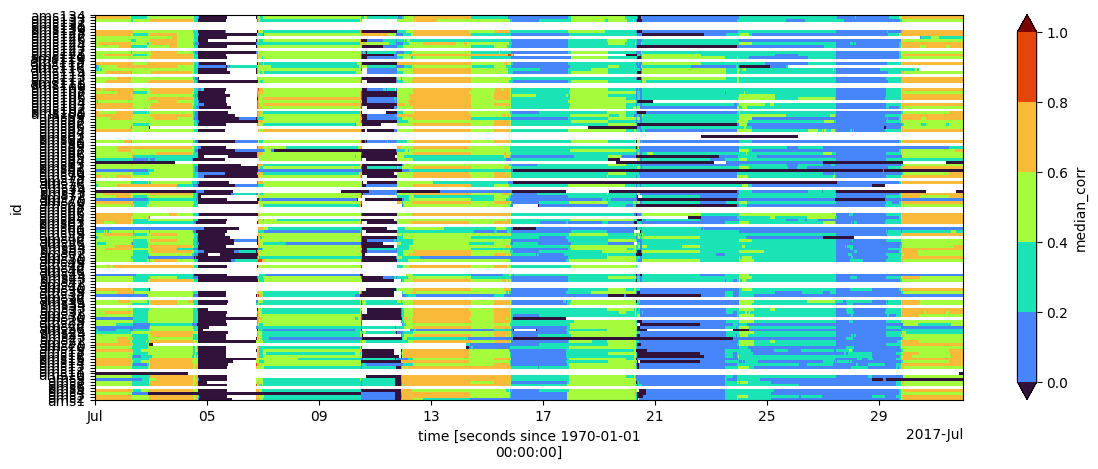

In [302]:
ds_pws.median_corr.plot(vmin=0, vmax=1, cmap='turbo', levels=6, figsize=(14, 5))

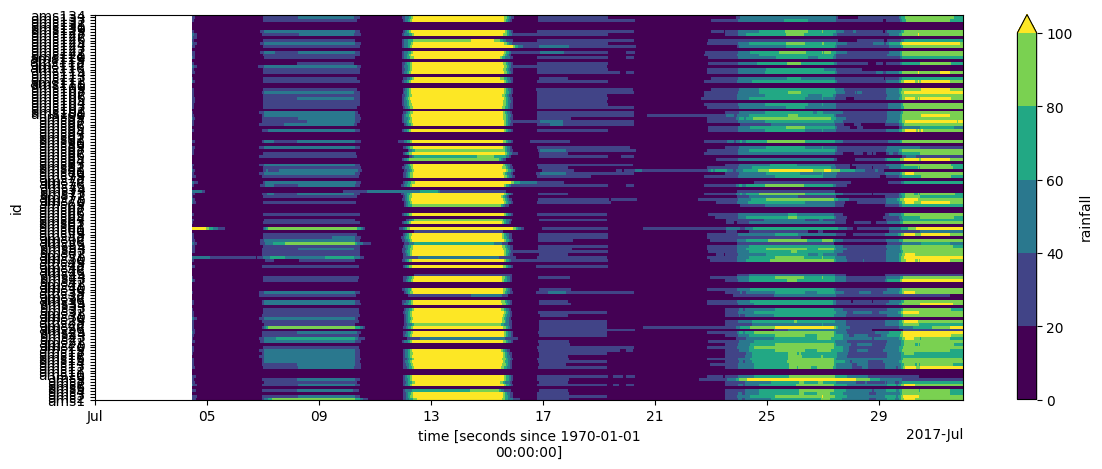

In [307]:
n_rainy_in_window = (ds_pws.rainfall > 0).rolling(time=1000).sum()
n_rainy_in_window.plot(vmin=0, vmax=100, cmap='viridis', levels=6, figsize=(14, 5))

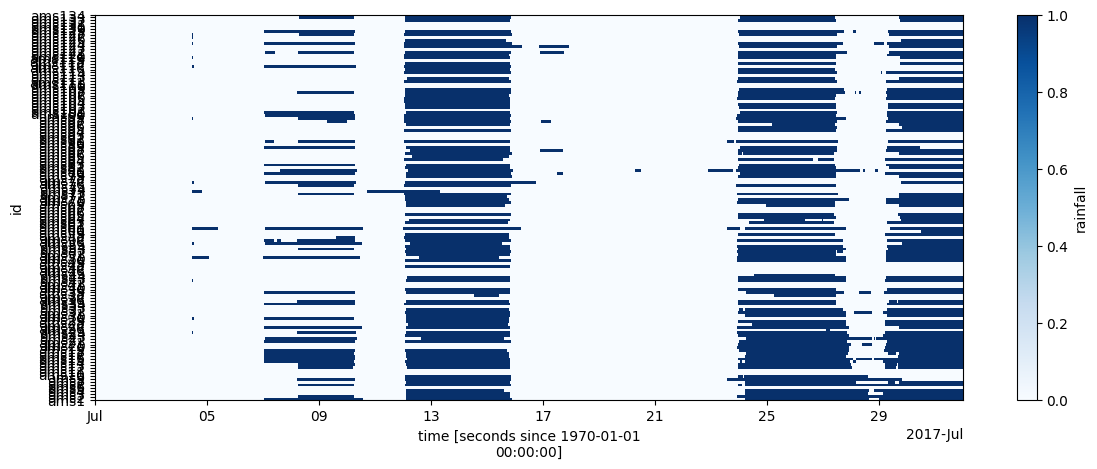

In [312]:
(n_rainy_in_window > 40).plot(cmap='Blues', figsize=(14, 5));

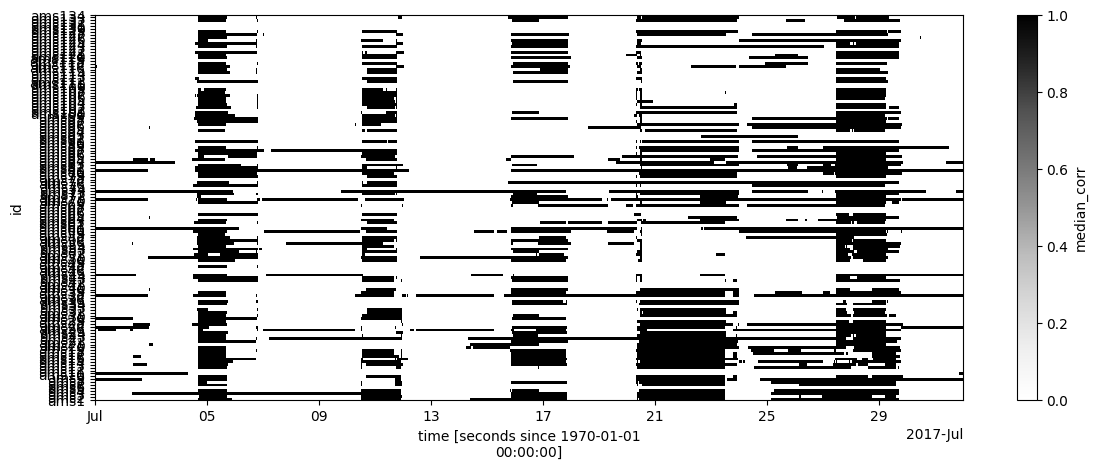

In [316]:
(ds_pws.median_corr < 0.2).plot(figsize=(14, 5), cmap='Grays');

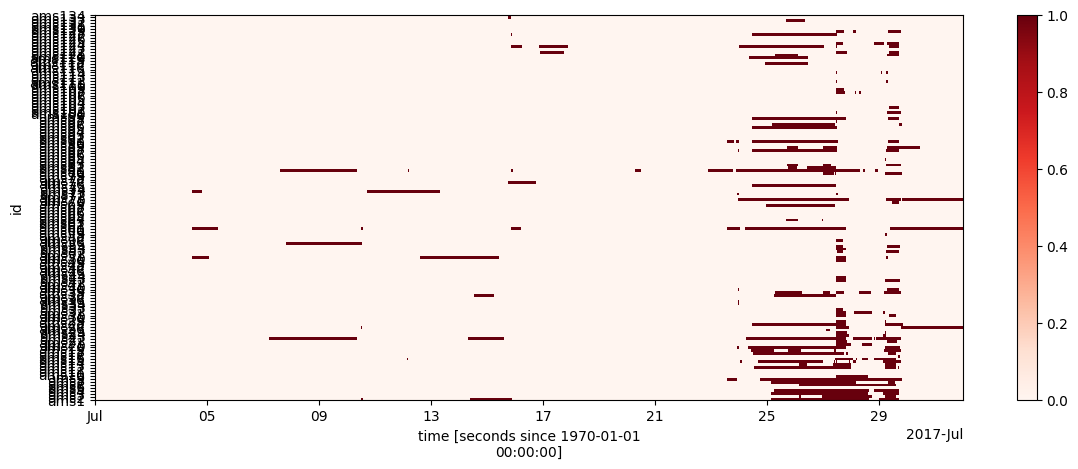

In [315]:
((n_rainy_in_window > 40) & (ds_pws.median_corr < 0.2)).plot(figsize=(14, 5), cmap='Reds');

## Cell below: variable and fixed evaluation period. I stopped the script after 4 hours, then it was still working on the first station.

In [14]:
%%time

for i, station_id in enumerate(ds_pws.id.data):  # enumerate(["ams1", "ams45", "ams17"]):
    print(station_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
        distance_matrix.sel(id=station_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=station_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=station_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, -1)).data, start=mint
        ):
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev

            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps
            if (
                cum_rainy_timesteps.sel(id=station_id, time=timestep)
                - cum_rainy_timesteps.sel(id=station_id).isel(time=j - mint + 1)
                >= mrain
            ):
                #print('fixed period')
                evaluation_period_start = j - mint +1
                evaluation_period_end = j

            # variable evaluation period if less than mrain rainy timesteps in the last mint timesteps (but before the considered period starts)
            elif (cum_rainy_timesteps.sel(id=station_id).isel(time=j).data - mrain) > 0:
                start_timestamp = (
                    cum_rainy_timesteps.sel(id=station_id)
                    .where(
                        cum_rainy_timesteps.sel(id=station_id).data
                        == (
                            cum_rainy_timesteps.sel(id=station_id).isel(time=j).data
                            - mrain
                        )
                    )
                    .dropna(dim="time")
                    .time.data
                )
                #print('variable period')
                #print(j)
                start_timestamp = start_timestamp[-1]

                evaluation_period_start = int(
                    ds_pws.number.sel(id=station_id)
                    .where(
                        ds_pws.number.sel(id=station_id).time.data == start_timestamp
                    )
                    .dropna(dim="time")
                    .data.item()
                )
                evaluation_period_end = j

            else:  
                # assign -1 to SO filter, we are in the 'warm up period' of the filter
                so_flag[i, j] = -1
                biascorrectiontable[i,j] = BCF_prev
                continue

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )

            if matches < mmatch:
            #filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

            else:
                # suppress runtime warning
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        
                        # pearson correlation with neighboring stations
                        corr = xr.corr(
                            ds_pws.rainfall.sel(id=station_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                        )
                        corr_values[k] = corr.data  

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws.rainfall.sel(id=station_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        ) - ds_pws.rainfall.sel(id=neighbor_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        )

                        bias = np.nanmean(delta_r) / np.nanmean(
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        )
                        bias_values[k] = bias
                        
                        median_correlation = np.median(corr_values)
                        
                        # if median correlation is above threshold gamma,
                        # calculate new bias correction factor
                        if median_correlation > gamma:
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCFnew = 1 / (1 + median_bias)
                            if np.abs(np.log(BCFnew / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCFnew
                                biascorrectiontable[i,j] = BCF_new

                        # if the median of the pearson correlation with the neighbors is too low, 
                        # it is a "station outlier"
                        else:
                            so_flag[i, j] = 1
                            biascorrectiontable[i,j] = BCF_prev
    so_flag.to_pickle('C:/Users/a002461/OPENSENSE/data/'+station_id+'.pkl')        


ams1


KeyboardInterrupt: 

In [ ]:
# add flags to dataset
ds_pws["so_flag"] = (("id", "time"), so_flag)
ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [ ]:
ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data_SO_flags.nc')

In [35]:
%%time

for i, station_id in enumerate(["ams1"]):  # enumerate(["ams1", "ams45", "ams17"]): enumerate(ds_pws.id.data): 
    #print(station_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
        distance_matrix.sel(id=station_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=station_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )
    #print(neighbors.data)

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=station_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, mint+5)).data, start=mint
        ):
            
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev
            #t1 = time.time()
            #if time.time() - tt > 30: # every now and then print some info
                #tt = time.time()
                #print('After 30 sec, station:', i, 'of', len(ds_pws.id), 'timestep:', j, 'of', len(ds_pws.time))
            
            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps

            evaluation_period_start = j - mint +1
            evaluation_period_end = j

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )
            print(matches)

            if matches < mmatch:
            # filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

3677
3662
3646
3629
3612
CPU times: total: 15.6 ms
Wall time: 23.2 ms


In [31]:
j

4036

In [32]:
matches

array(3612)

In [33]:
matches

array(3612)

In [34]:
mmatch


200